# Классификация рукописных чисел <u>полносвязанной</u> сетью

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import os

DATA_HOME = os.environ["DATA_HOME"]     # мне так удобно

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST(f'{DATA_HOME}/torchvision', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST(f'{DATA_HOME}/torchvision', download=True, train=False)

In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

X_data, то есть сами картинки, имеют тип dtype "unsigned int8", а вот лейблы имеют тип "int64". хочется, чтобы данные были в дробных числах

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

сразу преобразуем X_train и X_test во float (в дробные числа)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

 X_train и X_test имеют размерности 60 тысяч изображений и 10 тысяч соответственно, и сами изображения (они размером 28 на 28) -- это очень маленькие картинки, **поэтому мы и можем применять полносвязанную нейронную сеть для такой задачи**

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

Лейблы y_train и y_test -- они имеют соответствующий размер и у них нету дополнительной размерности. Это одномерный тензор, и поэтому мы обозначили X_train с большой буквы а y_train -- с маленькой, предполагая, что X_train -- это многомерный тензор, y -- это одномерный (поэтому с маленькой)

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

Как выглядят изображения

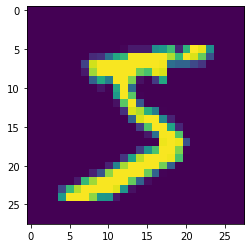

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Растянуть наши картинки в одномерный вектор признаков нам поможет функция `reshape`.
- потеряется некоторая информация о том, какие пиксели были рядом какие находились далеко, но в принципе нам этого хватит. 

In [10]:
# варианты, как это еще можно, по сути задачи лучше flatten (размеры не нужно вычислять)
(X_train.flatten(start_dim=1, end_dim=-1).shape, 
 X_train.view(-1, 28*28).shape, 
 X_train.view(X_train.shape[0], -1).shape,
 X_train.reshape([-1, 28 * 28]).shape,
 X_train.reshape([X_train.shape[0], -1]).shape,
 X_train.resize(X_train.shape[0], 28 * 28).shape)

/home/user1/envs/py310/lib64/python3/site-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([60000, 784]))

In [11]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [12]:
X_train.shape

torch.Size([60000, 784])

Сеть будет подбирать комбинацию сигмоид максимально близко выражающую векторное представление кадра по каждому классу (цифры 0-9):
- исходим из того, что зависимость класса от векторного представления достаточно различимая в шуме (погрешность рисования)

Сигмоидная активация - это вот то, что называют "добавить нелинейность"

Софтмакс на выходе не считаем, потому что сам по себе он нас тут не интересует, а встроенный `CrossEntropyLoss` по-умочанию входы нормирует софтмаксом самостоятельно.

In [13]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [14]:
torch.cuda.is_available()

True

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

Функция потерь - кросс-энтропия, потому что это loss, который используется в классификации.

Нужно подчеркнуть, что функция CrossEntropyLoss на вход принимает не вероятности, а те выходы, которые до софтмакса, то есть функция forward, которую мы написали, не содержала софтмакс, потому что мы хотим немножко ускорить наши вычисления, избежав софтмакса.

In [16]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [17]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    train_loss = 0
    for counter, start_index in enumerate(range(0, len(X_train), batch_size)):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        train_loss += loss_value.detach().cpu()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)

    # в loss хранится весь граф вычислений функции потерь, поэтому 
    # аппендить нужно только скопированное на ЦПУ поле .data, чтоб остальное CUDA 
    # могла освободить, в противном случе как тут происходит утечка памяти (хоть и незаметная, т.к. сеть маленькая)
    test_loss_history.append(loss(test_preds, y_test))
    train_loss_history.append(train_loss / counter)
    
    # доля правильных классов
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9055, device='cuda:0')
tensor(0.9144, device='cuda:0')
tensor(0.9197, device='cuda:0')
tensor(0.9217, device='cuda:0')
tensor(0.9185, device='cuda:0')
tensor(0.9267, device='cuda:0')
tensor(0.9246, device='cuda:0')
tensor(0.9271, device='cuda:0')
tensor(0.9262, device='cuda:0')
tensor(0.9378, device='cuda:0')
tensor(0.9368, device='cuda:0')
tensor(0.9335, device='cuda:0')
tensor(0.9345, device='cuda:0')
tensor(0.9370, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9343, device='cuda:0')
tensor(0.9378, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9395, device='cuda:0')
tensor(0.9371, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9405, device='cuda:0')
tensor(0.9401, device='cuda:0')
tensor(0.9446, device='cuda:0')
tensor(0.9411, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9441, device='cuda:0')
tensor(0.9446, device='cuda:0')
tensor(0.9465, device='cuda:0')
tensor(0

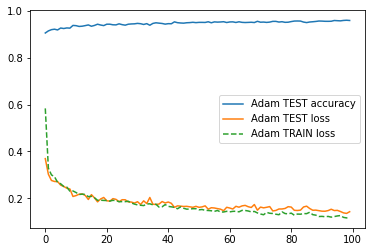

In [18]:
plt.plot([x.detach().cpu().tolist() for x in test_accuracy_history], label="Adam TEST accuracy")
plt.plot([x.detach().cpu().tolist() for x in test_loss_history], label="Adam TEST loss")
plt.plot([x.detach().cpu().tolist() for x in train_loss_history], ls="--", label="Adam TRAIN loss")

plt.legend();

Обычно (то что вы видите в эксперименте) колебания в лоссе меньше, чем колебания в accuracy, потому что accuracy -- это уже округлённые значения, а в loss учитываются вероятности, которые не так дискретны, соответственно не дают таких жёстких колебаний на графике. 

Есть если вы видите что у вас качество на train растёт гораздо лучше, если оно выходит на более высокие параметры в конце обучения, это значит, что вы имеете дело с явлением переобучения и ваша нейронная сеть, вместо того, чтобы выучивать какие-то новые вещи, она просто запоминает картинки. И это можно побороть с помощью 
- уменьшения параметров нейронной сети, 
- уменьшения количества слоёв и уменьшения их размера.

# Сравним Adam с SGD

In [19]:
mnist_net2 = MNISTNet(100)
mnist_net2.to(device)
optimizer2 = torch.optim.SGD(mnist_net2.parameters(), lr=1.0e-3)

test_accuracy_history2 = []
test_loss_history2 = []
train_loss_history2 = []

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    train_loss = 0
    for counter, start_index in enumerate(range(0, len(X_train), batch_size)):
        optimizer2.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net2.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        train_loss += loss_value.detach().cpu()
        
        optimizer2.step()

    test_preds = mnist_net2.forward(X_test)
    test_loss_history2.append(loss(test_preds, y_test))
    train_loss_history2.append(train_loss / counter)
    
    # доля правильных классов
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history2.append(accuracy)
    print(accuracy)

tensor(0.7759, device='cuda:0')
tensor(0.8427, device='cuda:0')
tensor(0.8648, device='cuda:0')
tensor(0.8765, device='cuda:0')
tensor(0.8825, device='cuda:0')
tensor(0.8894, device='cuda:0')
tensor(0.8961, device='cuda:0')
tensor(0.8974, device='cuda:0')
tensor(0.9005, device='cuda:0')
tensor(0.9023, device='cuda:0')
tensor(0.9051, device='cuda:0')
tensor(0.9068, device='cuda:0')
tensor(0.9086, device='cuda:0')
tensor(0.9100, device='cuda:0')
tensor(0.9114, device='cuda:0')
tensor(0.9139, device='cuda:0')
tensor(0.9146, device='cuda:0')
tensor(0.9147, device='cuda:0')
tensor(0.9164, device='cuda:0')
tensor(0.9163, device='cuda:0')
tensor(0.9173, device='cuda:0')
tensor(0.9185, device='cuda:0')
tensor(0.9196, device='cuda:0')
tensor(0.9200, device='cuda:0')
tensor(0.9205, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9209, device='cuda:0')
tensor(0.9223, device='cuda:0')
tensor(0.9236, device='cuda:0')
tensor(0.9233, device='cuda:0')
tensor(0.9236, device='cuda:0')
tensor(0

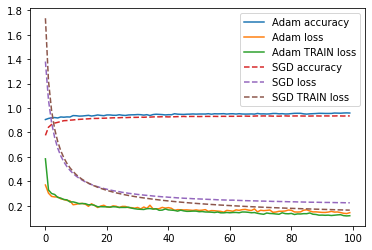

In [20]:
plt.plot([x.detach().cpu().tolist() for x in test_accuracy_history], label="Adam accuracy")
plt.plot([x.detach().cpu().tolist() for x in test_loss_history], label="Adam loss")
plt.plot([x.detach().cpu().tolist() for x in train_loss_history], label="Adam TRAIN loss")

plt.plot([x.detach().cpu().tolist() for x in test_accuracy_history2], ls="--", label="SGD accuracy")
plt.plot([x.detach().cpu().tolist() for x in test_loss_history2], ls="--", label="SGD loss")
plt.plot([x.detach().cpu().tolist() for x in train_loss_history2], ls="--", label="SGD TRAIN loss")

plt.legend();

Полносвязный слой может быть представлен как матричное умножение матрицы входов (X) и матрицы весов нейронов слоя (W), плюс вектор bias'ов слоя (b). 

В документации к классу `torch.nn.Linear` (полносвязному слою) написано следующее: Applies a linear transformation to the incoming data: $y = xA^T + b$. 
$А$ здесь – это то, как `PyTorch` хранит веса слоя. Но чтобы эта матрица совпала с W из предыдущего урока, нужно её сперва транспонировать.

Давайте реализуем функциональность `torch.nn.Linear` и сверим с оригиналом

In [28]:
# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
fc_out_alternative =  x @ w.T + b # torch.mm(x, torch.t(w)) + b

fc_out, fc_out_alternative

(tensor([[381., 682., 983.]], grad_fn=<AddmmBackward0>),
 tensor([[381., 682., 983.]]))

Проверим, что по ней правильно считается градиент. 

Функцию `backward()` в `PyTorch` можно посчитать только от скалярной функции (выход из такой функции – одно число). Это логично, так как loss-функция выдает всегда одно число. Но fc-слой, который мы проэмулировали, имел 3 выхода. Предлагаем их просуммировать, чтобы получить в итоге скалярную функцию. Заметим, впрочем, что можно было бы выбрать любую агрегирующую операцию, например умножение.

In [31]:
# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = torch.sum(x @ w.T + b) # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
